In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from scipy.integrate import ode, odeint
from time import time
from numba import jit

In [2]:
# Just-in-time compiling these two functions
# seems to gain about a factor 2 in speed.
# (Note that the first time the function is called,
# it is slower, since compilation takes place.)
# (Note also that you should never define and use
# a just-in-time compiled function in the same cell
# in a notebook, as it will be compiled every time)

@jit
def lorenz(x, sigma, rho, beta):
    # The Lorenz system (see Ch. 9 in Strogatz)
    xdot = sigma*(x[1] - x[0])
    ydot = x[0]*(rho - x[2]) - x[1]
    zdot = x[0]*x[1] - beta*x[2]
    return np.array([xdot, ydot, zdot])

@jit
def f(x, t):
    # Wrapper function for the lorenz equations
    sigma = 10.0
    rho   = 28.0
    beta  = 8/3
    return lorenz(x, sigma, rho, beta)

# Task A - Reproduce figure from assignment

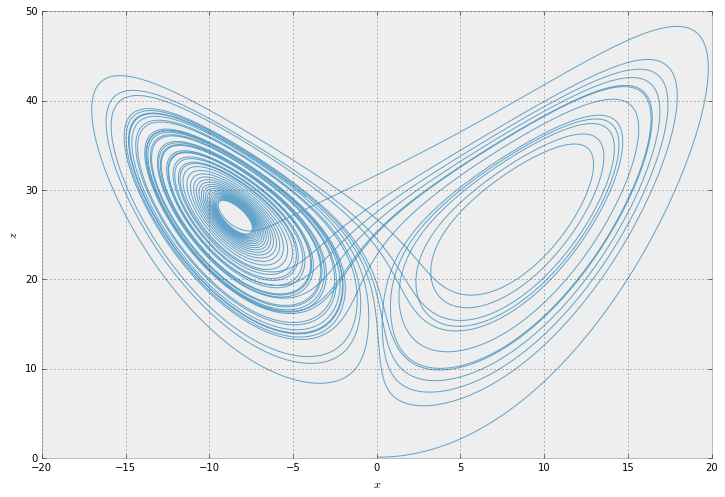

In [3]:
# Initial condition
x0 = [0.1,0.1,0.1]
# Times at which to get solution
T  = np.linspace(0, 40, 10000)
# Using odeint from scipy, which in turn uses lsoda
# This is a variable stepsize integrator.
X  = odeint(f, x0, T)
# Plotting
fig = plt.figure(figsize = (12, 8))
plt.plot(X[:,0], X[:,2], lw = 1, alpha = 0.75)
plt.xlabel('$x$')
plt.ylabel('$z$')

# Task B - Lyapunov exponent

In [4]:
from scipy.optimize import curve_fit

# Function to fit to the data. Note that the prefactor
# in this function must match initial separation.
def e(x, a):
    return 1e-6 * np.exp(a*x)

def delta(Tmax = 40, tol = 1e-8):
    # Choose random initial condition near origin
    x0 = 1e-2 * np.random.random(size = 3) + 0.1
    # Run trajectory until t = 40 to get
    # an initial condition 'on' the attractor
    x0 = odeint(f, x0, [0, 40], rtol = tol, atol=tol, mxstep = int(1e6))[-1,:]
    # create another initial condition by random perturbation
    dx = np.random.uniform(-1, 1, size = 3)
    # scale displacement vector to length 1e-6
    dx = 1e-6 * dx / np.sqrt(np.sum(dx**2))
    # Calculate two trajectories
    T  = np.linspace(0, Tmax, 5000)
    X1 = odeint(f, x0,    T)
    X2 = odeint(f, x0+dx, T)
    return T, np.sqrt(np.sum((X1 - X2)**2, axis = 1))

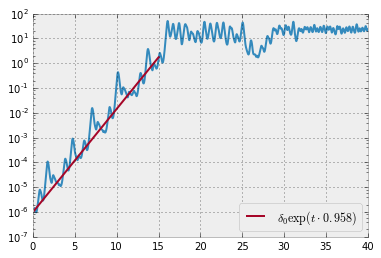

In [5]:
# Plot one example of separation as function of time
t, d = delta()

# From trial and error, a cutoff time of t=15 seems reasonable
imax = np.argmin(np.abs(t - 15))
(a,), pcov = curve_fit(e, t[:imax], d[:imax])
plt.plot(t, d)
plt.plot(t[:imax], e(t[:imax], a), label = '$\delta_0 \exp(t\cdot%.03f)$' % a)
plt.legend(loc = 'lower right')
plt.yscale('log')

Lyapunov exponent: 0.893783415426


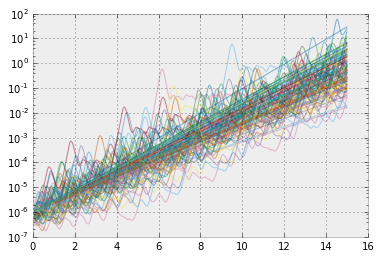

In [6]:
# repeat the above a large number of times
N = 50
lyapunov = 0
for i in range(N):
    t, d = delta(Tmax = 15)
    (a,), pcov = curve_fit(e, t, d)
    l, = plt.plot(t, d, lw = 1, alpha = 0.5)
    plt.plot(t, e(t, a), c = l.get_color(), lw = 1, alpha = 0.5)
    lyapunov += a
plt.yscale('log')
print('Lyapunov exponent:', lyapunov / N)

In [7]:
# repeat the above an even larger number of times
# now without plotting
N = 500
lyapunov = 0
for i in range(N):
    t, d = delta(Tmax = 15)
    (a,), pcov = curve_fit(e, t, d)
    lyapunov += a
print('Lyapunov exponent:', lyapunov / N)

Lyapunov exponent: 0.914892542158
